In [1]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

from rich import print
import joblib

args = dotdict()
args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints
args.factor = 5 # probsparse attn factor
args.e_layers = 4 # num of encoder layers
args.d_layers = 4 # num of decoder layers
args.dropout = 0.01 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'learned' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = -1
args.freq = 'h'

ts_length = 1440
max_batch = 64

enc_in = 10
dec_in = enc_in
c_out = 2
n_heads = 8
d_model = 256
d_ff = 256

from easydict import EasyDict as edict
from models.rnnp import RNNPredictor

model = RNNPredictor('LSTM', enc_in, 256, 256, c_out, nlayers=3, dropout=0.05, res_connection=False)


model_name = f'{d_model}d_modelx{d_ff}d_ffx{n_heads}heads_{args.e_layers}enc_layers_{args.d_layers}dec_layers'
print(f"Total parm of Model: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6}M")
# torch.Size([1, 96, 7]) torch.Size([1, 96, 4]) torch.Size([1, 72, 7]) torch.Size([1, 72, 4])
# print(batch_x.shape, batch_x_mark.shape, dec_inp.shape, batch_y_mark.shape)

print(model(torch.rand(1, 1, enc_in),model.init_hidden(1))[0].shape)


from pathlib import Path
import pickle
import numpy as np
from matplotlib import pyplot as plt



with open('/home/ljb/all_data_new.pkl', 'rb') as f:
    arr = pickle.load(f)
    print(arr[0].shape)

downsample_arr = []
downsample_rate = int(17280 / ts_length)
for ts in arr:
    downsample_arr.append(ts)

class TimeSeries:
    def __init__(self, raw) -> None:
        raw = torch.from_numpy(raw).float()
        self.x = raw[:, :-1]
        self.y = F.one_hot(raw[:, -1:].long(), 2)[:,0].float()
        pass
    
    

all_arr = []
skip = 0
for i in downsample_arr:
    if len(i) < 1900:
        print(i.shape)
        skip += 1
        continue
    all_arr.append(TimeSeries(i))
print(skip)

import random

train_arr = random.sample(all_arr, int(len(all_arr) * 0.8))
val_arr = list(set(all_arr) - set(train_arr))
SAMPLE_FREQ = downsample_rate # 1 obs per minute


SIGMA = 720 #average length of day is 24*60*12 = 17280 for comparison
from math import sqrt, pi, exp
import gc

def normalize(y):
    mean = y[:,0].mean().item()
    std = y[:,0].std().item()
    y[:,0] = (y[:,0]-mean)/(std+1e-16)
    mean = y[:,1].mean().item()
    std = y[:,1].std().item()
    y[:,1] = (y[:,1]-mean)/(std+1e-16)
    return y

class SleepDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        file
    ):
        self.targets,self.data,self.ids = joblib.load(file)
            
    def downsample_seq_generate_features(self,feat, downsample_factor = SAMPLE_FREQ):
        # downsample data and generate features
        if len(feat)%SAMPLE_FREQ==0:
            feat = np.concatenate([feat,np.zeros(SAMPLE_FREQ-((len(feat))%SAMPLE_FREQ))+feat[-1]])
        feat = np.reshape(feat, (-1,SAMPLE_FREQ))
        feat_mean = np.mean(feat,1)
        feat_std = np.std(feat,1)
        feat_median = np.median(feat,1)
        feat_max = np.max(feat,1)
        feat_min = np.min(feat,1)

        return np.dstack([feat_mean,feat_std,feat_median,feat_max,feat_min])[0]
    def downsample_seq(self,feat, downsample_factor = SAMPLE_FREQ):
        # downsample data
        if len(feat)%SAMPLE_FREQ==0:
            feat = np.concatenate([feat,np.zeros(SAMPLE_FREQ-((len(feat))%SAMPLE_FREQ))+feat[-1]])
        feat = np.reshape(feat, (-1,SAMPLE_FREQ))
        feat_mean = np.mean(feat,1)
        return feat_mean
    
    def gauss(self,n=SIGMA,sigma=SIGMA*0.15):
        # guassian distribution function
        r = range(-int(n/2),int(n/2)+1)
        return [1 / (sigma * sqrt(2*pi)) * exp(-float(x)**2/(2*sigma**2)) for x in r]
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        X = self.data[index][['anglez','enmo']]
        y = self.targets[index]
        
        # turn target inds into array
        target_guassian = np.zeros((len(X),2))
        for s,e in y:
            st1,st2 = max(0,s-SIGMA//2),s+SIGMA//2+1
            ed1,ed2 = e-SIGMA//2,min(len(X),e+SIGMA//2+1)
            target_guassian[st1:st2,0] = self.gauss()[st1-(s-SIGMA//2):]
            target_guassian[ed1:ed2,1] = self.gauss()[:SIGMA+1-((e+SIGMA//2+1)-ed2)]
            gc.collect()
        y = target_guassian
        gc.collect()
        X = np.concatenate([self.downsample_seq_generate_features(X.values[:,i],SAMPLE_FREQ) for i in range(X.shape[1])],-1)
        gc.collect()
        y = np.dstack([self.downsample_seq(y[:,i],SAMPLE_FREQ) for i in range(y.shape[1])])[0]
        gc.collect()
        y = normalize(torch.from_numpy(y))
        X = torch.from_numpy(X)
        return X.unsqueeze(0), y.unsqueeze(0)

processed_ds = 'processed_ds.pkl'
if processed_ds is None:
    ds = SleepDataset("/home/ljb/train_data.pkl")
    # processed_ds = [ds[0], ds[1]]
    # ds = [ds[0], ds[1]]
    # ds = SleepDataset(train_arr)
    dl = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=True, num_workers=24)

    processed_ds = [(x, y) for x, y in tqdm(ds) if y.max() > 0]
    pickle.dump(processed_ds, open('processed_ds.pkl', 'wb'))

    Path(model_name).mkdir(exist_ok=True)
else:
    processed_ds = pickle.load(open(processed_ds, 'rb'))


val_pre_epoch = 1
model = model.cuda()
max_length = ts_length*max_batch
def train_one_epoch(dl, model, loss_fn, optimizer, e, scheduler=None):
    model.train()
    train_loss = []
    # y_pred = None
    for i, (x, y) in enumerate(dl):
        # if y.max() <0:
        #     continue
        if len(x.shape) == 4:
            x = x[0]
            y = y[0]
        # try:
        hidden = model.init_hidden(1)
        x = x.float().permute(1, 0, 2).cuda()
        y = y.float().permute(1, 0, 2).cuda()
        for i in range(x.shape[0] // max_length):
            hidden = model.repackage_hidden(hidden)
            # hidden_ = model.repackage_hidden(hidden)
            x_ = x[i*max_length:(i+1)*max_length]
            y_ = y[i*max_length:(i+1)*max_length]
            optimizer.zero_grad()
            
            '''Loss1: Free running loss'''
            # outVal = x_[0].unsqueeze(0)
            # outVals=[]
            # hids1 = []
            # for i in range(x_.size(0)):
            #     outVal, hidden_, hid = model.forward(outVal, hidden_,return_hiddens=True)
            #     outVals.append(outVal)
            #     hids1.append(hid)
            # outSeq1 = torch.cat(outVals,dim=0)
            # hids1 = torch.cat(hids1,dim=0)
            # loss1 = loss_fn(outSeq1.view(1,-1), y_.view(1,-1))

            '''Loss2: Teacher forcing loss'''
            outSeq2, hidden, hids2 = model.forward(x_, hidden, return_hiddens=True)
            loss2 = loss_fn(outSeq2.view(1, -1), y_.view(1, -1))

            '''Loss3: Simplified Professor forcing loss'''
            # loss3 = loss_fn(hids1.view(1,-1), hids2.view(1,-1).detach())

            '''Total loss = Loss1+Loss2+Loss3'''
            # loss = loss1+loss2+loss3
            loss2.backward()
            train_loss.append(loss2.item())
            optimizer.step()
            torch.cuda.empty_cache()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
            torch.cuda.empty_cache()
        # except Exception as e:
        #     print(x.shape, y.shape)
        #     raise e
        
    if scheduler is not None:
        scheduler.step()

    train_loss = np.average(train_loss)
    if e % 1 == 0:
        print(">"*11+f"Epoch {e} Train Loss: "+str(train_loss)+">"*11)
    if e % val_pre_epoch == 0:
        torch.save(model.state_dict(), f'./{model_name}/model_{e}.pth')

epoch = 10
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# scheduler = None
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch, eta_min=1e-4)
loss_fn = torch.nn.MSELoss()
# loss_fn = torch.nn.BCELoss()
# print("Start training...")
# for i in range(1, epoch+1):
#     train_one_epoch(processed_ds, model, loss_fn, optimizer, i, scheduler)

Total parm of Model: 1.583362M

torch.Size([1, 1, 2])

(252457, 13)

0

In [2]:
def test_one_series(x, model):
    print(x.shape)
    model.eval()
    with torch.no_grad():
        x = x.float().permute(1, 0, 2).cuda()
        hidden = model.init_hidden(1)
        ret = []
        for i in range(max(x.shape[0] // max_length, 1)):
            hidden = model.repackage_hidden(hidden)
            # hidden_ = model.repackage_hidden(hidden)
            x_ = x[i*max_length:(i+1)*max_length]
            outSeq2, _, _ = model.forward(x_, hidden, return_hiddens=True)
            print(outSeq2)
            ret.append(outSeq2)
    return torch.cat(ret, dim=0)

torch.Size([1, 32491, 10])

tensor([[[ 0.3723,  0.3561]],

        [[ 0.1508,  0.3575]],

        [[ 0.0210,  0.2455]],

        ...,

        [[ 0.0607, -0.0330]],

        [[ 0.0622, -0.0271]],

        [[ 0.0640, -0.0211]]], device='cuda:0')

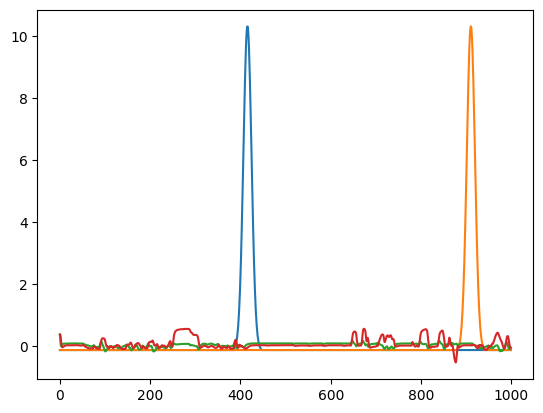

In [3]:
model.load_state_dict(torch.load('256d_modelx256d_ffx8heads_4enc_layers_4dec_layers/model_10.pth'))

for (x, y) in processed_ds:
    # plt.plot(x[0, :, 1].cpu().numpy()/100)
    plt.plot(y[0,:1000].cpu().numpy())    
    outSeq2 = test_one_series(x, model)
    plt.plot(outSeq2[:1000, 0].cpu().numpy())    
    break